In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.transforms import v2

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
# MODEL_SUFFIX = "convnet-exp2"
MODEL_SUFFIX = "mlp-randaug-exp2"
BATCH_SIZE = 64
EPOCHS = 50

In [5]:
# set tensorboard "log_dir" to "logs"
writer = SummaryWriter(f"logs/fashion-mnist_{MODEL_SUFFIX}")

In [6]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        v2.RandAugment(),
    ]
)

inference_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=train_transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=inference_transform,
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

num_classes = len(torch.unique(train_data.train_labels))

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]), torch.int64


/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


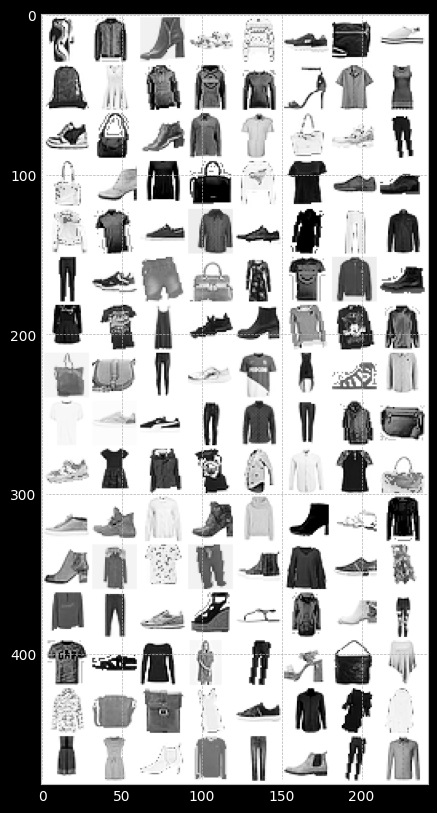

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

        
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# write to tensorboard
writer.add_image("fashion_mnist_images", img_grid)

In [10]:
# Initialize model
model = M.NeuralNetwork(c, dx1, dx2, num_classes)
# model = M.ResNet(1, 18, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnet(c, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnetV2(c, M.ResidualBlock, num_classes=num_classes)
# model = M.ConvNet(c, dx1, dx2, num_classes=num_classes)
model = model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [13]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, f"{MODEL_SUFFIX}.pth")

T.fit(
    model, 
    train_dataloader, 
    test_dataloader, 
    loss_fn, 
    optimizer, 
    n_epochs=EPOCHS, 
    checkpoint_path=checkpoint_path, 
    writer=writer
)
 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.32batch/s, loss=0.602]


Test Performance: 
 Accuracy: 75.30%, Avg loss: 0.6800 

Test Performance: 
 Accuracy: 80.61%, Avg loss: 0.5350 

Elapsed time: 8.64 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 2
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.08batch/s, loss=0.636]


Test Performance: 
 Accuracy: 78.41%, Avg loss: 0.5924 

Test Performance: 
 Accuracy: 83.73%, Avg loss: 0.4597 

Elapsed time: 8.52 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 3
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.04batch/s, loss=0.543]


Test Performance: 
 Accuracy: 80.75%, Avg loss: 0.5317 

Test Performance: 
 Accuracy: 85.24%, Avg loss: 0.4142 

Elapsed time: 8.52 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 4
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.94batch/s, loss=0.51] 


Test Performance: 
 Accuracy: 80.84%, Avg loss: 0.5177 

Test Performance: 
 Accuracy: 85.39%, Avg loss: 0.4109 

Elapsed time: 8.54 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 5
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 57.05batch/s, loss=0.466]


Test Performance: 
 Accuracy: 82.50%, Avg loss: 0.4760 

Test Performance: 
 Accuracy: 86.53%, Avg loss: 0.3797 

Elapsed time: 8.22 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 6
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.55batch/s, loss=0.575]


Test Performance: 
 Accuracy: 82.99%, Avg loss: 0.4636 

Test Performance: 
 Accuracy: 86.75%, Avg loss: 0.3691 

Elapsed time: 8.60 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 7
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.82batch/s, loss=0.375]


Test Performance: 
 Accuracy: 82.38%, Avg loss: 0.4723 

Test Performance: 
 Accuracy: 86.03%, Avg loss: 0.3913 

Elapsed time: 8.40 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 8
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.75batch/s, loss=0.313]


Test Performance: 
 Accuracy: 84.06%, Avg loss: 0.4294 

Test Performance: 
 Accuracy: 87.47%, Avg loss: 0.3546 

Elapsed time: 8.57 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 9
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 53.44batch/s, loss=0.423]


Test Performance: 
 Accuracy: 84.14%, Avg loss: 0.4264 

Test Performance: 
 Accuracy: 86.95%, Avg loss: 0.3634 

Elapsed time: 8.78 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 10
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 53.35batch/s, loss=0.385]


Test Performance: 
 Accuracy: 83.64%, Avg loss: 0.4366 

Test Performance: 
 Accuracy: 86.35%, Avg loss: 0.3771 

Elapsed time: 8.79 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 11
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 53.46batch/s, loss=0.424]


Test Performance: 
 Accuracy: 84.62%, Avg loss: 0.4160 

Test Performance: 
 Accuracy: 87.48%, Avg loss: 0.3447 

Elapsed time: 8.77 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 12
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.63batch/s, loss=0.265]


Test Performance: 
 Accuracy: 85.35%, Avg loss: 0.3931 

Test Performance: 
 Accuracy: 87.93%, Avg loss: 0.3358 

Elapsed time: 8.59 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 13
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.74batch/s, loss=0.426]


Test Performance: 
 Accuracy: 85.56%, Avg loss: 0.3928 

Test Performance: 
 Accuracy: 87.94%, Avg loss: 0.3348 

Elapsed time: 8.57 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 14
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.65batch/s, loss=0.439]


Test Performance: 
 Accuracy: 85.86%, Avg loss: 0.3822 

Test Performance: 
 Accuracy: 88.11%, Avg loss: 0.3312 

Elapsed time: 8.43 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 15
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.60batch/s, loss=0.548]


Test Performance: 
 Accuracy: 85.39%, Avg loss: 0.3902 

Test Performance: 
 Accuracy: 88.21%, Avg loss: 0.3321 

Elapsed time: 8.44 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 16
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.20batch/s, loss=0.303]


Test Performance: 
 Accuracy: 86.08%, Avg loss: 0.3728 

Test Performance: 
 Accuracy: 88.48%, Avg loss: 0.3187 

Elapsed time: 8.65 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 17
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 53.84batch/s, loss=0.317]


Test Performance: 
 Accuracy: 86.26%, Avg loss: 0.3642 

Test Performance: 
 Accuracy: 88.45%, Avg loss: 0.3220 

Elapsed time: 8.71 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 18
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 53.97batch/s, loss=0.445]


Test Performance: 
 Accuracy: 86.56%, Avg loss: 0.3609 

Test Performance: 
 Accuracy: 88.67%, Avg loss: 0.3183 

Elapsed time: 8.69 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 19
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.84batch/s, loss=0.286]


Test Performance: 
 Accuracy: 86.80%, Avg loss: 0.3554 

Test Performance: 
 Accuracy: 88.56%, Avg loss: 0.3136 

Elapsed time: 8.55 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 20
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.75batch/s, loss=0.528]


Test Performance: 
 Accuracy: 86.76%, Avg loss: 0.3537 

Test Performance: 
 Accuracy: 88.59%, Avg loss: 0.3131 

Elapsed time: 8.57 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 21
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 54.93batch/s, loss=0.344]


Test Performance: 
 Accuracy: 87.09%, Avg loss: 0.3460 

Test Performance: 
 Accuracy: 88.77%, Avg loss: 0.3121 

Elapsed time: 8.54 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 22
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 56.55batch/s, loss=0.441]


Test Performance: 
 Accuracy: 86.29%, Avg loss: 0.3632 

Test Performance: 
 Accuracy: 87.20%, Avg loss: 0.3387 

Elapsed time: 8.29 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 23
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 56.67batch/s, loss=0.342]


Test Performance: 
 Accuracy: 86.92%, Avg loss: 0.3466 

Test Performance: 
 Accuracy: 88.38%, Avg loss: 0.3164 

Elapsed time: 8.28 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 24
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 56.61batch/s, loss=0.23] 


Test Performance: 
 Accuracy: 87.25%, Avg loss: 0.3372 

Test Performance: 
 Accuracy: 88.81%, Avg loss: 0.3083 

Elapsed time: 8.29 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Epoch 25
-------------------------------


100%|██████████| 469/469 [00:08<00:00, 55.09batch/s, loss=0.348]


Test Performance: 
 Accuracy: 87.37%, Avg loss: 0.3390 

Test Performance: 
 Accuracy: 88.93%, Avg loss: 0.3054 

Elapsed time: 8.52 seconds

Saved PyTorch Model State to models/fashion-mnist/mlp-randaug-exp1.pth
Done!


In [14]:
from torchviz import make_dot

In [15]:
pred_labels = model(images)

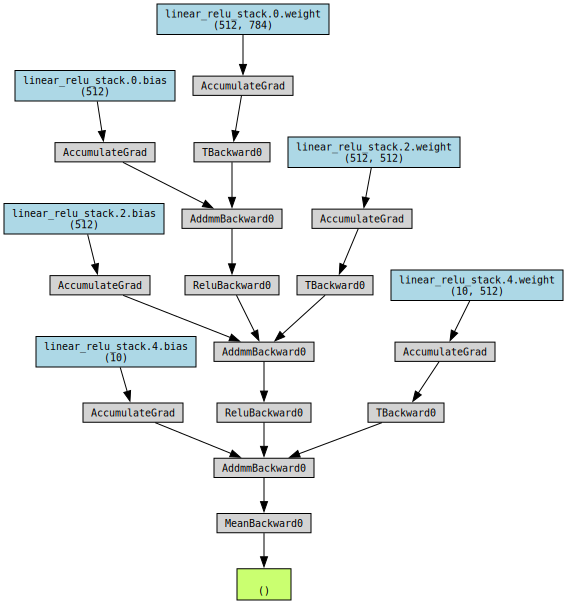

In [16]:
make_dot(pred_labels.mean(), params=dict(model.named_parameters()))